## Setup


Setup of this Jupyter Notebook ensures that MatplotLib works and figures are nicely displayed and stored. Furthermore useful modules are imported. (This was copied from this repository: https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb )

In [138]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# Common imports
import numpy as np
import pandas as pd
import os
import sklearn

# to make this notebook's output stable across runs 
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Get the data

Function to fetch the latest data at every time

In [139]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    

In [140]:
fetch_housing_data()


Function to load housing data 

In [141]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Data exploration

In [142]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [143]:
housing.info()
#Inspect feature ocean_proximity
housing["ocean_proximity"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [144]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


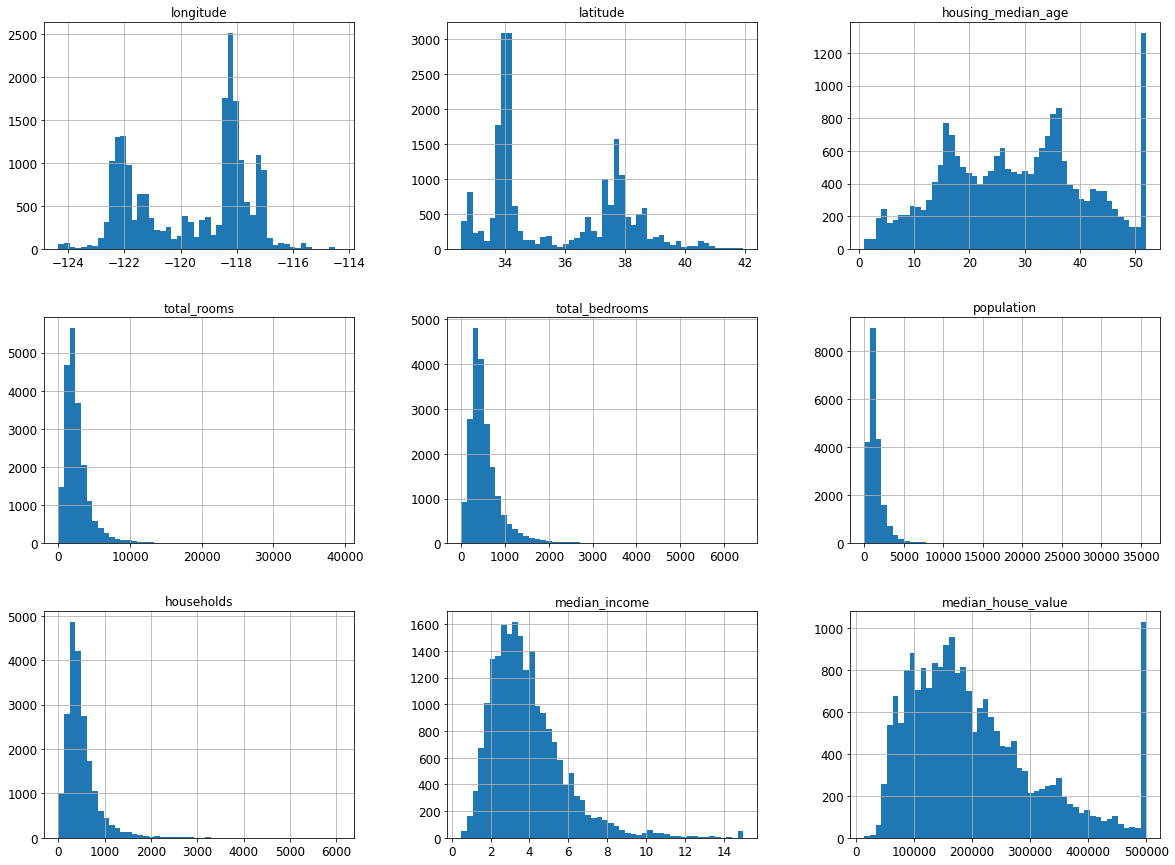

In [145]:
housing.hist(bins = 50, figsize= (20,15))
plt.show()


Split data in train and test set.\
**Important**: *In order to prevent biases the test set is directly generated and should never contain instances that belonged previously to
the train set. To guarantee this we use each instances identifier to decide in which set it goes, thereby even if the dataset is updated
instances from the test set don't end up in the training set.* 

In [146]:
import hashlib
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1]<256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash = hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [147]:
housing_with_id = housing.reset_index() #adds an index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Create stratified sets based on the attribute median_income.\
*The sets should be representative for the whole population in order to prevent sampling biases. To do so 
it can be ensured that the distribution in important features in a sample (looking at occurences in the different categories) is similar to the distribution in the population.*

In [148]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5) #divide by 1.5 and use ceil to round to get categories
housing["income_cat"].where(housing["income_cat"]< 5,5.0, inplace = True) #all entries with income_cat > 5 belong to cat 5 now

In [149]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [150]:
housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [151]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3.0    0.350775
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039729
Name: income_cat, dtype: float64

In [152]:
#Remove income_cat to get original dataset
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis = 1, inplace = True)

## Data Visualization

In [153]:
# Generate copy to play around with it
housing = strat_train_set.copy()

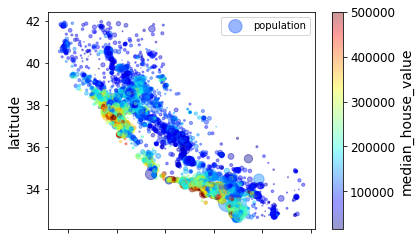

In [154]:
# Visualize geographical data
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
                    s = housing["population"]/100, label = "population",
                    c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True
)
plt.legend()

In [155]:
# Inspect correlation coefficients with Pearson correlation
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688435
total_rooms           0.134157
housing_median_age    0.113284
households            0.064943
total_bedrooms        0.048268
population           -0.025376
longitude            -0.047355
latitude             -0.143235
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

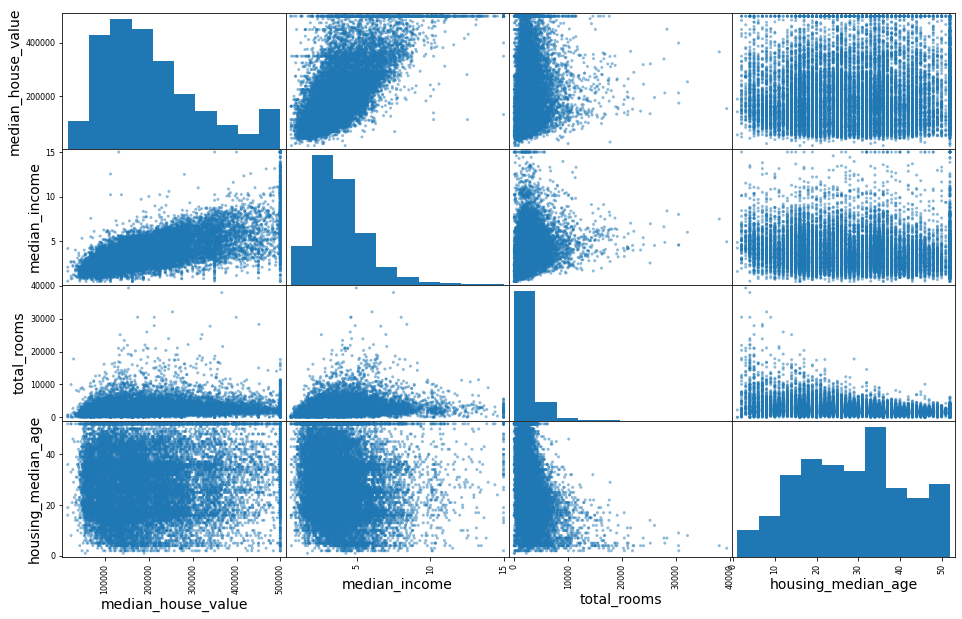

In [156]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (16,10))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

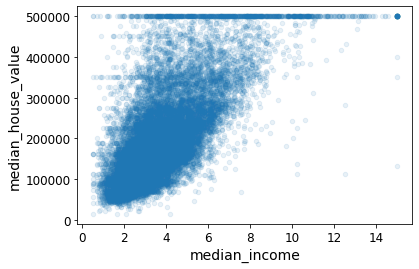

In [157]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

## Generation of new attributes

In [158]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [159]:
# Investigate the correlation between target variable and new features
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.688435
rooms_per_household         0.150216
total_rooms                 0.134157
housing_median_age          0.113284
households                  0.064943
total_bedrooms              0.048268
population_per_household   -0.022975
population                 -0.025376
longitude                  -0.047355
latitude                   -0.143235
bedrooms_per_room          -0.259775
Name: median_house_value, dtype: float64

In [160]:
housing = strat_train_set.drop("median_house_value", axis = 1) #drop is not automatically inplace instead a copy is generated
housing_labels = strat_train_set["median_house_value"].copy() #here we have to make a copy to not change the original target data

## Data Cleaning

In [161]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        182
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [162]:
# Handle missing values with Imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median") # imputer computes median of each attribute and stores it in its statistics_ instance variable
# new df without categorical attribute ocean_proximity
housing_num = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num) #imputer is applied to all numerical attributes

SimpleImputer(strategy='median')

In [163]:
imputer.statistics_
#housing_num.median().values

array([-118.5   ,   34.26  ,   29.    , 2124.    ,  433.    , 1164.    ,
        408.5   ,    3.5332])

In [164]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

## Handling Text and Categorical data


In [165]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
#housing_cat_encoded
print(encoder.classes_)


['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [166]:
from sklearn.preprocessing import OneHotEncoder
# because a ML model could assume that categorical values as numbers are more if the numbers are closer together,
# this is not necessarely the case and we use OneHotEncoding instead to not introduce any bias here
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

# quicker: use LabelBinarizer
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [167]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [168]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [169]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [170]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [171]:
housing_prepared.shape

(18576, 16)

## Select and train a model


In [172]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [173]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[5:10]
some_labels = housing_labels.iloc[5:10]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: \t", lin_reg.predict(some_data_prepared))
print("Labels:\t", list(some_labels))


Predictions: 	 [249297.3553559   74341.15578281 193382.54534226 267863.19677784
  66807.12635791]
Labels:	 [229000.0, 68300.0, 133300.0, 386200.0, 54000.0]


In [174]:
from sklearn.metrics import mean_squared_error
# measure the performance
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)
# we have most probably underfitting here -> choose another model


68451.25887361675


In [175]:
from sklearn.tree import DecisionTreeClassifier
tree_reg = DecisionTreeClassifier()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

KeyboardInterrupt: 

In [ ]:
# use cross validation instead of creating a single validation set
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [82844.2723142  82435.27046489 82125.01402018 83392.43960623
 80036.23761914 82809.83648625 80098.60657371 79921.9884314
 79773.13052619 83878.63654118]
Mean: 81731.54325833617
Standard deviation: 1518.8789362513596


In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error",cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [68061.4189211  64562.28720642 65238.99288534 69788.06373188
 70853.13397233 69577.89493198 69591.98333778 74763.23453298
 67808.12181661 67650.81078858]
Mean: 68789.59421249887
Standard deviation: 2747.2169926378397


In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
#forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10) #fitting is done inside cross-validation
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [48787.70508076 46048.80322471 49368.26477769 51956.66871324
 49792.4572201  49877.59328103 50168.43768051 50006.13494304
 49544.31475957 50653.39550346]
Mean: 49620.37751841235
Standard deviation: 1434.8925224506806


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators' : [3, 10, 30],
    'max_features': [2,4,6,8],
    'bootstrap': [False]},
    {'n_estimators' : [3, 10],
    'max_features': [2,3,4]
    }
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=30)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

61171.80359320833 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53820.87115737211 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
51130.66117759105 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
57786.34673557846 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
51318.062343508245 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
48759.22513724859 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}
56928.9147794264 {'bootstrap': False, 'max_features': 6, 'n_estimators': 3}
50921.48570644834 {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}
49021.21558943184 {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}
56457.58885073161 {'bootstrap': False, 'max_features': 8, 'n_estimators': 3}
50690.31690020778 {'bootstrap': False, 'max_features': 8, 'n_estimators': 10}
49135.04032735079 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
62569.93343150655 {'max_features': 2, 'n_estimators': 3}
54683.84749

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [180]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)


[(0.3101406053023962, 'median_income'),
 (0.11626796602290394, 'INLAND'),
 (0.0967250323396184, 'pop_per_hhold'),
 (0.09146219949842141, 'longitude'),
 (0.08922094698556911, 'latitude'),
 (0.07571090920674867, 'bedrooms_per_room'),
 (0.06230176855878029, 'rooms_per_hhold'),
 (0.0429110681770925, 'housing_median_age'),
 (0.02128021294076837, 'population'),
 (0.02089369762532258, 'total_rooms'),
 (0.019810849766415183, 'total_bedrooms'),
 (0.01945890435344582, 'households'),
 (0.014326672920030275, '<1H OCEAN'),
 (0.010083513658009932, 'NEAR BAY'),
 (0.009314120456269047, 'NEAR OCEAN'),
 (9.153218820835314e-05, 'ISLAND')]

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)


In [ ]:
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 
final_rmse

47759.91438802495

## Exercise


In [ ]:
from sklearn.svm import SVR

#forest_reg.fit(housing_prepared, housing_labels)
param_grid_SVR = [{
    'kernel' : ('linear', 'poly', 'rbf'),
    'C': [0.1, 1, 10]
}]
support_reg = SVR()
grid_search = GridSearchCV(support_reg, param_grid_SVR, cv = 5, scoring = 'neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_estimator_

SVR(kernel='linear')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid_SVR = [{
    'kernel' : ('linear', 'poly', 'rbf'),
    'C': [0.1, 1, 5, 10, 20]
}]
support_reg = SVR()
random_search = RandomizedSearchCV(support_reg, param_grid_SVR, cv = 5, scoring = 'neg_mean_squared_error')
random_search.fit(housing_prepared, housing_labels)

random_search.best_estimator_


KeyboardInterrupt: 

In [176]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [177]:
k = 5
indices_top_features = indices_of_top_k(feature_importances,k)
print(indices_top_features)

[ 0  1  7  9 12]


In [181]:
np.array(attributes)[indices_top_features]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [185]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3101406053023962, 'median_income'),
 (0.11626796602290394, 'INLAND'),
 (0.0967250323396184, 'pop_per_hhold'),
 (0.09146219949842141, 'longitude'),
 (0.08922094698556911, 'latitude')]